# Пробное решение задачи (без ML) от All cups. Соревнование ВКонтакте-Мини ML. Граф дружбы (https://cups.online/ru/workareas/vk-miniml/)

## Условие задачи
Дан неориентированный граф дружб в виде списка ребер.
Описание колонок:
*   u — идентификатор меньшего пользователя,
*   v — идентификатор большего пользователя,
*   t — время жизни ребра (1 — ребро появилось совсем недавно, 99 — очень давно)
*   h — абстрактная степень взаимодействия между пользователями.

Для каждого пользователя, представленного в графе, необходимо составить неупорядоченный список из не более чем 10 рекомендаций. метрика для оценки: recall@10

Для каждого пункта необходимо сформировать txt файл в формате:
user_id: recommended_user_id_1,recommended_user_id_2,...

### Подготовка

In [2]:
#Импорт библиотек
import pandas as pd 
import numpy as np
import json
from tqdm.notebook import tqdm

In [3]:
#Загрузка данных
df = pd.read_csv("/content/drive/MyDrive/Coding/data_tr.csv")

### Изучение данных

In [4]:
df.sample(5)

,u,v,t,h
32036,56560,64721,60,5
44627,35617,68689,68,5
32659,16089,72302,36,7
11818,29472,75553,53,0
22907,3577,48074,51,6


In [5]:
df[df.t == 0]

,u,v,t,h


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48609 entries, 0 to 48608
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u       48609 non-null  int64
 1   v       48609 non-null  int64
 2   t       48609 non-null  int64
 3   h       48609 non-null  int64
dtypes: int64(4)
memory usage: 1.5 MB


### Объявление дополнительных функций

In [7]:
#Разбиение на временные группы. Чем дольше связь, тем меньше значимость группы
#Можно было бы воспользоваться встроенным pandas.qcut, 
#но хотелась предусмотреть возможность делить на разные по размеру группы
def group_by_time(time_col):
  if time_col >= 0 and time_col <= 10:
    return 9
  if time_col >= 11 and time_col <= 21:
    return 8
  if time_col >= 22 and time_col <= 32:
    return 7
  if time_col >= 33 and time_col <= 43:
    return 6
  if time_col >= 44 and time_col <= 54:
    return 5
  if time_col >= 55 and time_col <= 65:
    return 4
  if time_col >= 66 and time_col <= 76:
    return 3
  if time_col >= 77 and time_col <= 87:
    return 2
  if time_col >= 88 and time_col <= 99:
    return 1
  else:
    print(time_col)
    return 0

In [8]:
#Функция объединяем словарей путем сложения рангов
def join_repeat_friends(all_friends, best_friend_dict):
  for fr_id, rang in best_friend_dict.items():
    if fr_id in all_friends:
      all_friends[fr_id] = all_friends[fr_id] + rang
    else:
      all_friends[fr_id] = rang
  return all_friends 

In [9]:
#Функция сортировки итогового словаря по величине ранга и выбира лучщих кандидатов    
def sort_by_rang(best_frieds_dict):
  new_dict = {value: key for key, value in best_frieds_dict.items()}
  hights_keys = list(new_dict.keys())
  hights_keys.sort(reverse=True)
  hights_keys = hights_keys[0:9] 
  best_friends_ids = [new_dict[key] for key in hights_keys]
  return best_friends_ids  

In [14]:
#Функция поиска друзей для уникального пользователя 
#(сначала из столбца U, а потом по столбцу V)
def search_for_friend_u(one_id, df):
  #Ищем друзей первого уровня для пользователя one_id
  level_1_friends_u = df.query('u == @one_id and v != @one_id').sort_values(by = 'r', ascending = False).head(15)
  level_1_friends_v = df.query('u != @one_id and v == @one_id').sort_values(by = 'r', ascending = False).head(15)

  #Ищем по столбцу U
  all_level_2_friends_u = {}
  for ind, row in level_1_friends_u.iterrows():
    one_r = row.r
    one_v = row.v

    #Находим друзей второго уровня (по столбцу u) для пользователя one_u по пользователю one_v
    level_2_friends_u = df.query('u != @one_id and v == @one_v')
    level_2_friends_dict_u = {row.u: row.r*one_r for ind, row in level_2_friends_u.iterrows()}

    #Объединяем словари всех пользователей первого уровня путем сложения рангов
    all_level_2_friends_u = join_repeat_friends(all_level_2_friends_u, level_2_friends_dict_u)

  #Ищем по столбцу V
  all_level_2_friends_v = {}
  for ind, row in level_1_friends_v.iterrows():
    one_r = row.r
    one_u = row.u

    #Находим друзей второго уровня (по столбцу u) для пользователя one_u по пользователю one_v
    level_2_friends_v = df.query('v != @one_id and u == @one_u')
    level_2_friends_dict_v = {row.v: row.r*one_r for ind, row in level_2_friends_v.iterrows()}

    #Объединяем словари всех пользователей первого уровня путем сложения рангов
    all_level_2_friends_v = join_repeat_friends(all_level_2_friends_v, level_2_friends_dict_v)


  #Объединяем словари всех друзей, найденных по столбцам V и U
  all_level_2_friends = join_repeat_friends(all_level_2_friends_u, all_level_2_friends_v)
  
  #Сортируем итоговый словарь по величине ранга и выбираем 10 лучщих кандидатов  функцией sort_by_rang 
  best_friend_ids = sort_by_rang(all_level_2_friends)  
  return best_friend_ids

### Предобработка

In [10]:
df = df.astype({'u': str, 'v': str})

In [11]:
#Разделение связей на временные группы
df['r_t'] = df.t.apply(group_by_time)

#Разделение связей на группы по типу связей. Чтобы не было нулевых рангов добавляем 0.00000001
df['r_h'] = df.h + 0.0000000001

#Расчет ранга связи
df['r'] = np.array(df['r_t'].values) * np.array(df['r_h'].values)

#Проверка
df.sort_values(by = 'r', ascending = False).head(5)

,u,v,t,h,r_t,r_h,r
24304,13444,35707,4,9,9,9.0,81.0
30427,7300,16931,3,9,9,9.0,81.0
14748,35091,47323,3,9,9,9.0,81.0
30323,50889,84723,9,9,9,9.0,81.0
3509,40,69618,1,9,9,9.0,81.0


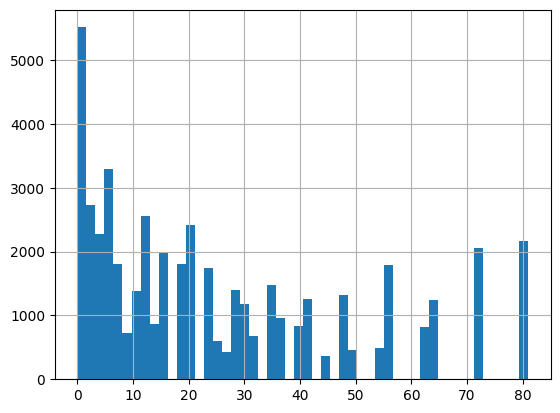

In [12]:
df.sort_values(by = 'r', ascending = False).r.hist(bins = 50);

In [15]:
#Поиск друзей второго уровня для всех уникальных пользователей из столбца U
all_friends_u = {}
uniq_u = list(df.u.unique())
uniq_u.sort()
for uid in tqdm(uniq_u):
  fr_list = search_for_friend_u(uid, df)
  if fr_list:
    friends = {uid: search_for_friend_u(uid, df)}
    all_friends_u = {**all_friends_u, **friends}

  0%|          | 0/9300 [00:00<?, ?it/s]

In [16]:
#Поиск друзей второго уровня для всех уникальных пользователей из столбца V, которых нет в столбце U
uids_u = set(df.u.unique())
uids_v = set(df.v.unique())
uniq_v = list(uids_v.difference(uids_u))

all_friends_v = {}
for uid in tqdm(uniq_v):
  fr_list = search_for_friend_u(uid, df)
  if fr_list:
    friends = {uid: search_for_friend_u(uid, df)}
    all_friends_v = {**all_friends_u, **friends}

  0%|          | 0/4189 [00:00<?, ?it/s]

In [17]:
#Создание строки с идентификаторами пользователей и их друзей
string_u = ''
for key in all_friends_u:
  new_row = f'''{key}: {",".join(all_friends_u[key])} \n'''
  string_u = string_u + new_row

string_v = ''
for key in all_friends_v:
  new_row = f'''{key}: {", ".join(all_friends_v[key])}\n'''
  string_v = string_v + new_row

rez_string = string_u + string_v

In [18]:
#Запись ответа в файл
with open('vk_18.txt', 'w') as f:
    f.write(rez_string)

In [19]:
rez_string.strip()

'10003: 16267,17641,18759,20830,42454,8129,37432,3284,26419 \n10012: 28681,56450,461,76914,32215,19611,36490,84324,71193 \n10036: 44077,18751,38544,37936,45798,59504,52037,51132,61879 \n10046: 16252,22754,68083,22182,45722,17503,54391,70920,33773 \n1005: 23106,4661,12473,8716,18649,12093,23792,14104,52620 \n10073: 22111,14806,1182,8468,8302,15500,13499,11092,7220 \n10077: 50002,34711,19675,32215,58743,40560 \n10086: 45663,33875,42632,58999,80849,11955,9389,53663,28929 \n10102: 32215,2812,541,22290,15090,6428,16763,4531,13751 \n10117: 8432,27841,48507,7609,10184,55613,21972,14158,44622 \n10133: 8460,10864,4098,47087,22602,32288,74408,3564,52391 \n1014: 9242 \n10141: 9202 \n10163: 221,4400,13815,37064,8451,17192 \n10168: 13311,24719,42604,42261,24010,27940,14589,5317,17146 \n10172: 49235,79627,15524,52620,66910,6357,4534,3519,23095 \n10175: 22602,32215,1940,17949,33510,5055,12423,16108,10367 \n10176: 13617,14696,12795,13190,24570,33234,46715,52678,32617 \n10184: 7609,6801,22766,8432,4194